## Evaluation de  modeles

In [1]:
import pandas as pd

# Créer les données
data = {
    'Métrique/algorithme': ['Exactitude', 'Fonction de perte'],
    'VGG16': ['95.58%', '0.1606'],
    'DeepLabV3': ['94.80%', '0.3181'],
    'HED': ['94.80%', '0.1195'],
    'FCN': ['96.27%', '0.6485'],
    'U-Net': ['96.54%', '0.0903']
}

# Créer le DataFrame
df = pd.DataFrame(data)

# Afficher le tableau
df


Métrique/algorithme   VGG16 DeepLabV3     HED     FCN   U-Net
0          Exactitude  95.58%    94.80%  94.80%  96.27%  96.54%
1   Fonction de perte  0.1606    0.3181  0.1195  0.6485  0.0903

## Unet with vgg16 backbone

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import os

# Define paths
image_dir = '/kaggle/input/prepared-dataset/train/img'
mask_dir = '/kaggle/input/prepared-dataset/train/mask'

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]
        
        return np.array(images), np.array(masks)
    
    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        return img

# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))

def build_vgg16_unet(input_shape):
    # Load the VGG16 model pre-trained on ImageNet, without the top classification layers
    vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the VGG16 layers to prevent them from being trained
    vgg16.trainable = False

    # Encoder (VGG16)
    c1 = vgg16.get_layer('block1_conv2').output
    c2 = vgg16.get_layer('block2_conv2').output
    c3 = vgg16.get_layer('block3_conv3').output
    c4 = vgg16.get_layer('block4_conv3').output
    c5 = vgg16.get_layer('block5_conv3').output

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[vgg16.input], outputs=[outputs])
    return model

# Build and compile the model
model = build_vgg16_unet(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=30)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725405635.157730     101 service.cc:145] XLA service 0x7d04700027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725405635.157782     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725405635.157789     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725405692.757228     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/3 ━━━━━━━━━━━━━━━━━━━━ 2:05 63s/step - accuracy: 0.0705 - loss: 2.2884

2024-09-03 23:22:17.631815: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=2,k3=0} for conv (f32[32,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-03 23:22:17.720606: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.088890356s
Trying algorithm eng25{k2=2,k3=0} for conv (f32[32,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation

3/3 ━━━━━━━━━━━━━━━━━━━━ 178s 58s/step - accuracy: 0.5682 - loss: 1.2495 - val_accuracy: 0.9480 - val_loss: 0.4384
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9389 - loss: 0.3875 - val_accuracy: 0.9482 - val_loss: 0.2804
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9494 - loss: 0.2710 - val_accuracy: 0.9492 - val_loss: 0.2500
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9467 - loss: 0.2407 - val_accuracy: 0.9511 - val_loss: 0.1800
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9516 - loss: 0.1740 - val_accuracy: 0.9560 - val_loss: 0.1424
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9547 - loss: 0.1417 - val_accuracy: 0.9575 - val_loss: 0.1249
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9582 - loss: 0.1246 - val_accuracy: 0.9586 - val_loss: 0.1104
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9593 - loss: 0.1078 - val_accuracy: 0.9600 - val_loss: 0.1030
Epoch 9/30
3/3 ━━━━━━━━━

In [3]:
# Save the model
model.save('vgg16_backbone_unet_model.h5')

In [4]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.9671 - loss: 0.0709
Validation Loss: 0.07070449739694595
Validation Accuracy: 0.9675104022026062


1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step


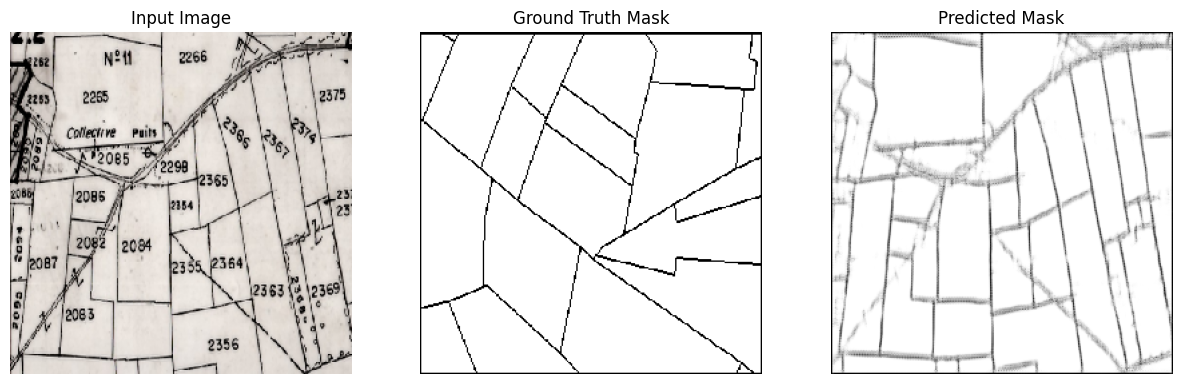

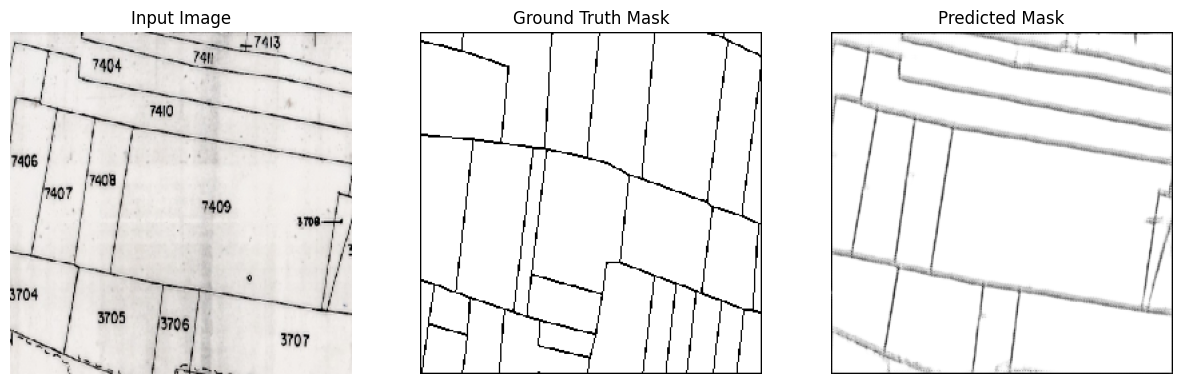

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2
import os

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/train/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

def remove_artifacts(image):
    # Convert image to 8-bit format (0-255 range)
    image_8bit = (image * 255).astype(np.uint8)
    
    # Convert image to grayscale for inpainting
    gray = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2GRAY)
    
    # Create a mask where white pixels represent the areas to be inpainted
    mask = np.zeros_like(gray)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    
    # Inpaint the image to remove artifacts
    inpainted = cv2.inpaint(image_8bit, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    # Convert the image back to float format for consistency
    inpainted = inpainted.astype(np.float32) / 255.0
    return inpainted

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([remove_artifacts(load_image(img_path)) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/vgg16_backbone_unet_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        # axs[1].imshow(masks[i].squeeze(), cmap='gray')
        # axs[1].set_title('Ground Truth Mask')
        # axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)


##  Apply early sotpping and 30 epochs and data augmentation

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
image_dir = '/kaggle/input/prepared-dataset/train/img'
mask_dir = '/kaggle/input/prepared-dataset/train/mask'

    
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        
        if self.augment:
            self.aug = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )
    
    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]
        
        if self.augment:
            images, masks = self.augment_images(images, masks)
        
        return np.array(images), np.array(masks)
    
    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        return img

    def augment_images(self, images, masks):
        augmented_images = []
        augmented_masks = []
        for img, mask in zip(images, masks):
            img = np.expand_dims(img, 0)
            mask = np.expand_dims(mask, 0)
            augmented = self.aug.flow(img, batch_size=1, shuffle=False).next()
            augmented_mask = self.aug.flow(mask, batch_size=1, shuffle=False).next()
            augmented_images.append(augmented[0])
            augmented_masks.append(augmented_mask[0])
        return np.array(augmented_images), np.array(augmented_masks)



# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(256, 256))


def build_vgg16_unet(input_shape):
    # Load the VGG16 model pre-trained on ImageNet, without the top classification layers
    vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the VGG16 layers to prevent them from being trained
    vgg16.trainable = False

    # Encoder (VGG16)
    c1 = vgg16.get_layer('block1_conv2').output
    c2 = vgg16.get_layer('block2_conv2').output
    c3 = vgg16.get_layer('block3_conv3').output
    c4 = vgg16.get_layer('block4_conv3').output
    c5 = vgg16.get_layer('block5_conv3').output

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[vgg16.input], outputs=[outputs])
    return model



# Build and compile the model
model = build_vgg16_unet(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stopping])


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7383 - loss: 0.6877 - val_accuracy: 0.9473 - val_loss: 0.1849
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 851ms/step - accuracy: 0.9500 - loss: 0.1630 - val_accuracy: 0.9553 - val_loss: 0.1198
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 850ms/step - accuracy: 0.9562 - loss: 0.1148 - val_accuracy: 0.9579 - val_loss: 0.1160
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - accuracy: 0.9612 - loss: 0.1045 - val_accuracy: 0.9616 - val_loss: 0.0914
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step - accuracy: 0.9627 - loss: 0.0897 - val_accuracy: 0.9642 - val_loss: 0.0838
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 879ms/step - accuracy: 0.9642 - loss: 0.0859 - val_accuracy: 0.9643 - val_loss: 0.0807
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 890ms/step - accuracy: 0.9643 - loss: 0.0818 - val_accuracy: 0.9650 - val_loss: 0.0783
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 884ms/step - accuracy: 0.9646 - loss: 0.0797 - val_accuracy: 0.9646 - val_loss: 0

In [7]:
# Save the model
model.save('best_model.h5')

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9685 - loss: 0.0671
Validation Loss: 0.067201167345047
Validation Accuracy: 0.9684650301933289


In [5]:
# Define paths to your testing dataset and output directory
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
output_dir = '/kaggle/working/predicted_output'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

def remove_artifacts(image):
    # Convert image to 8-bit format (0-255 range)
    image_8bit = (image * 255).astype(np.uint8)
    
    # Convert image to grayscale for inpainting
    gray = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2GRAY)
    
    # Create a mask where white pixels represent the areas to be inpainted
    mask = np.zeros_like(gray)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    
    # Inpaint the image to remove artifacts
    inpainted = cv2.inpaint(image_8bit, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    # Convert the image back to float format for consistency
    inpainted = inpainted.astype(np.float32) / 255.0
    return inpainted

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_images = np.array([remove_artifacts(load_image(img_path)) for img_path in test_image_paths])

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Save predictions to the output directory
def save_predictions(predictions, output_dir, test_image_paths):
    for i, prediction in enumerate(predictions):
        # Convert prediction to 8-bit format (0-255 range)
        prediction_8bit = (prediction.squeeze() * 255).astype(np.uint8)
        
        # Define the output file path
        output_path = os.path.join(output_dir, os.path.basename(test_image_paths[i]))
        
        # Save the predicted mask
        cv2.imwrite(output_path, prediction_8bit)

# Save the predictions
save_predictions(predictions, output_dir, test_image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


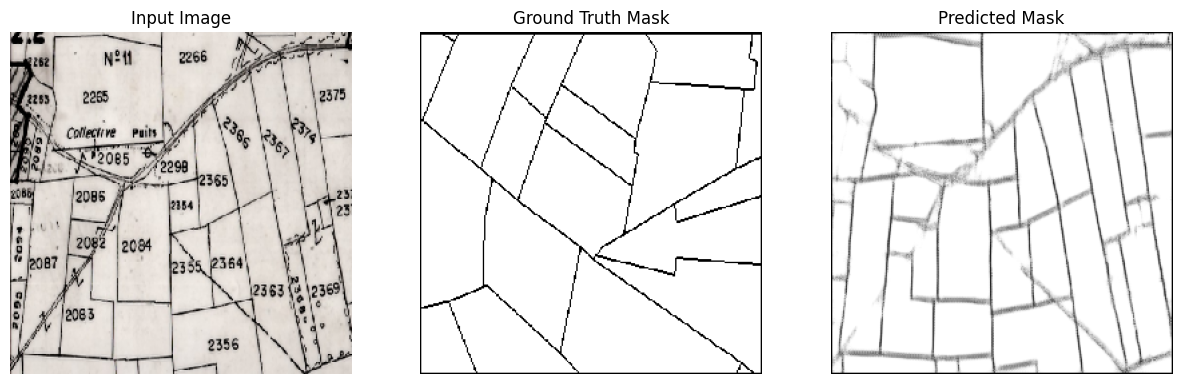

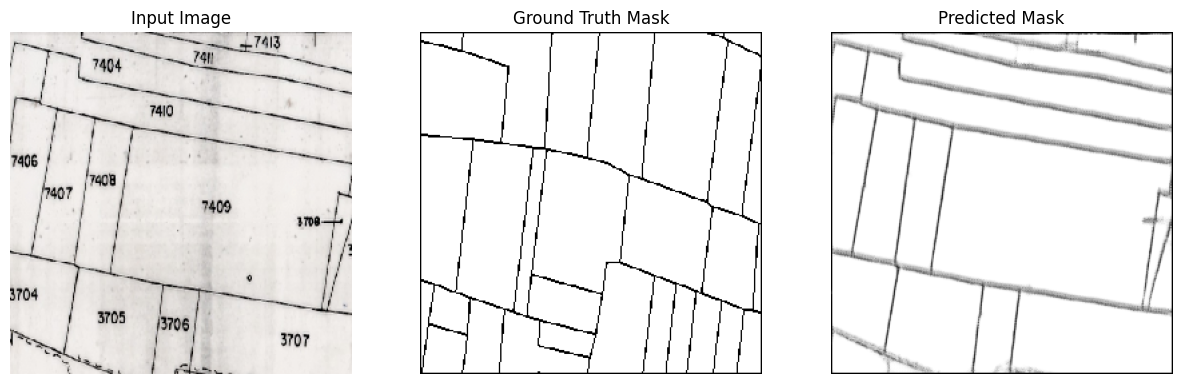

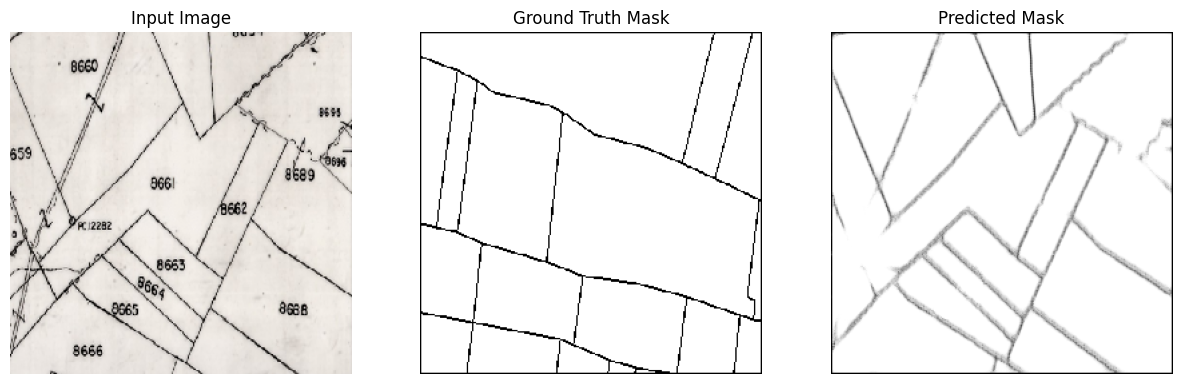

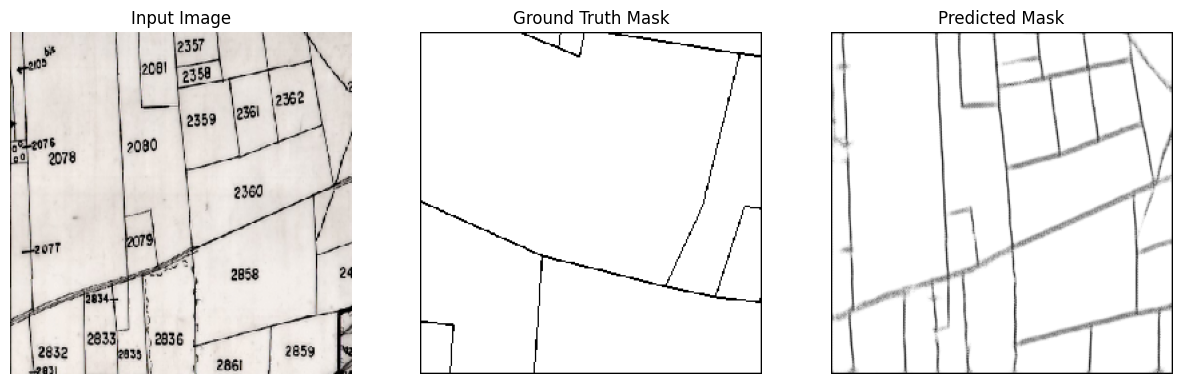

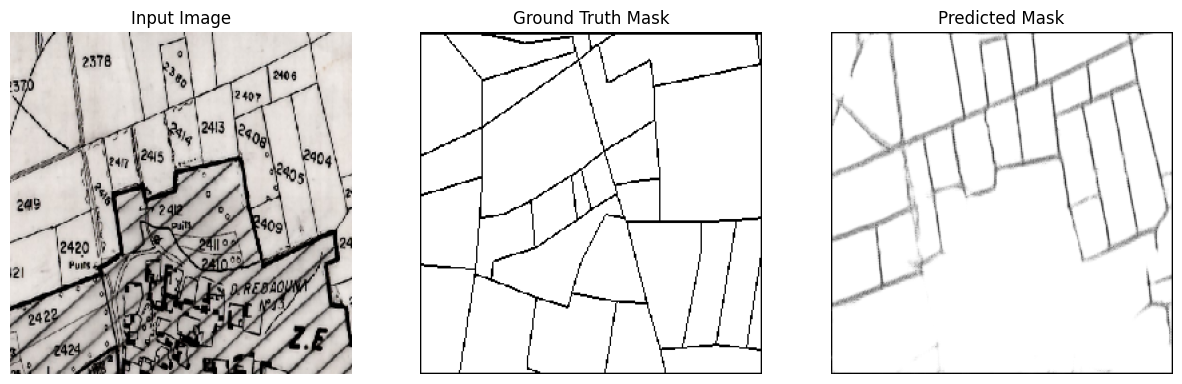

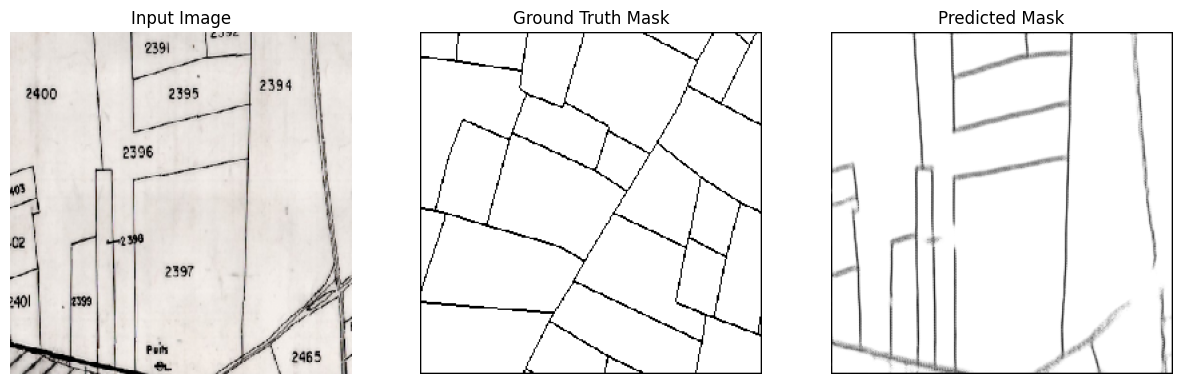

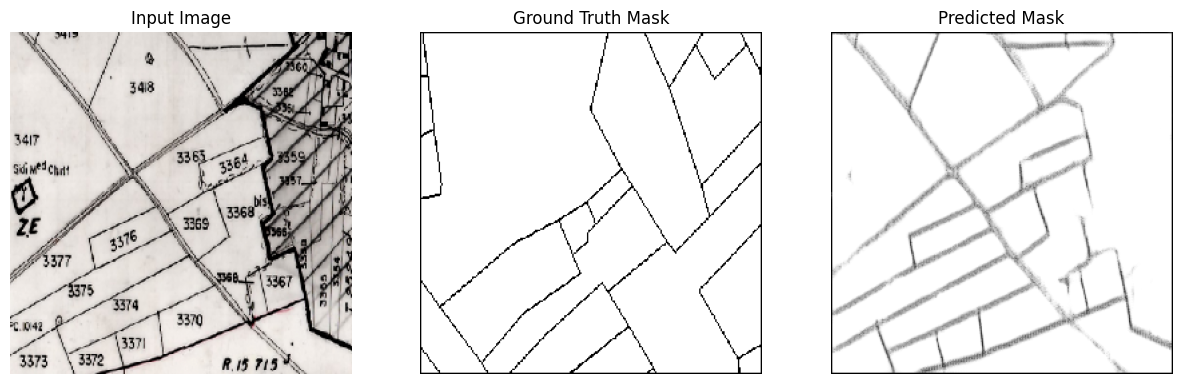

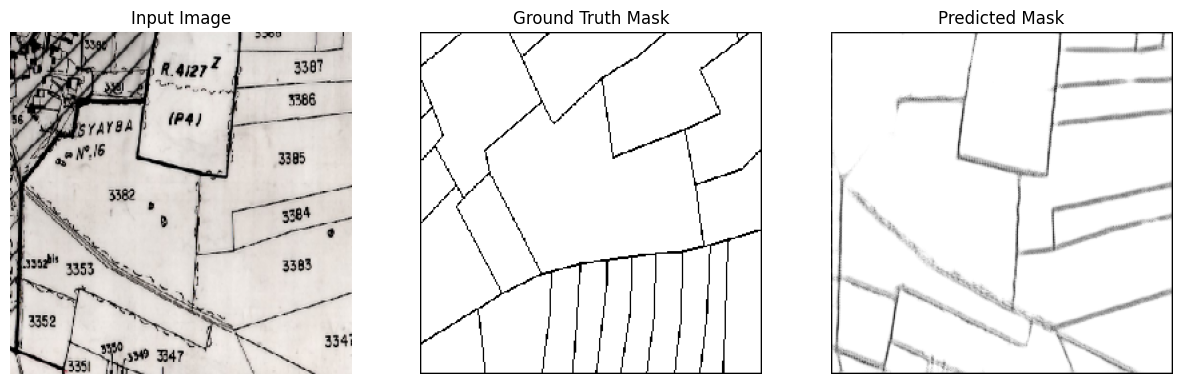

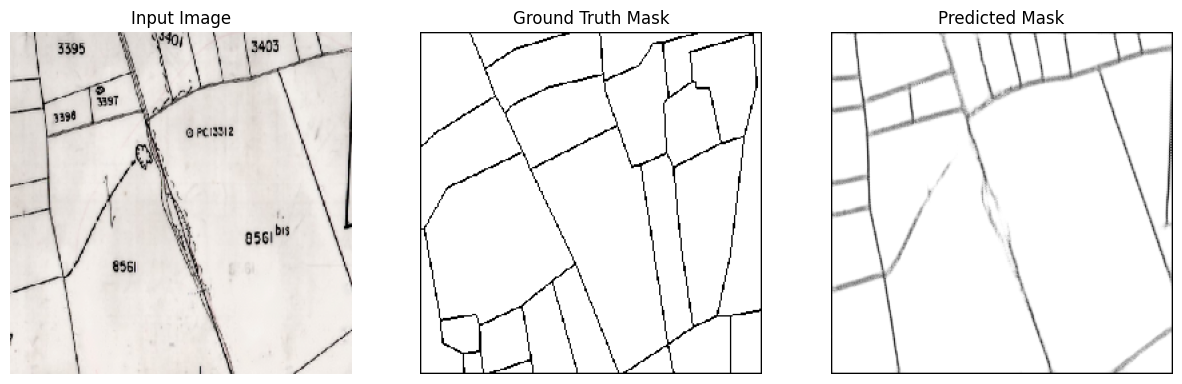

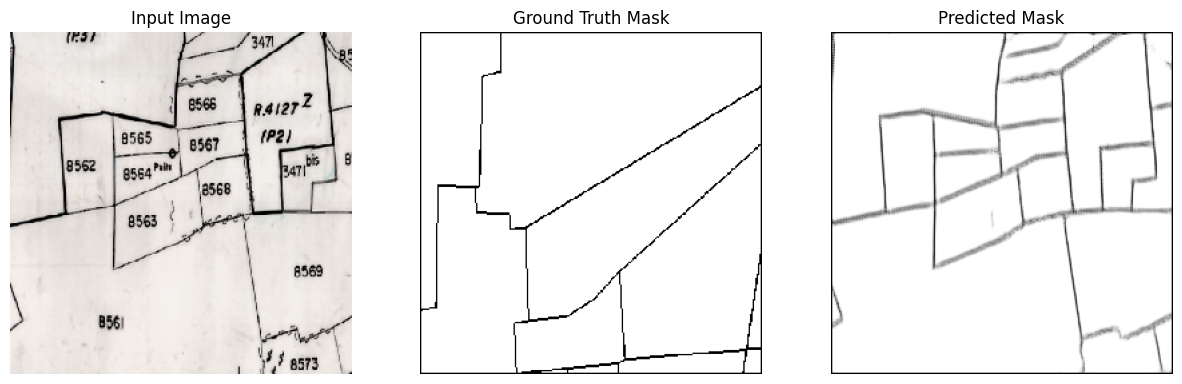

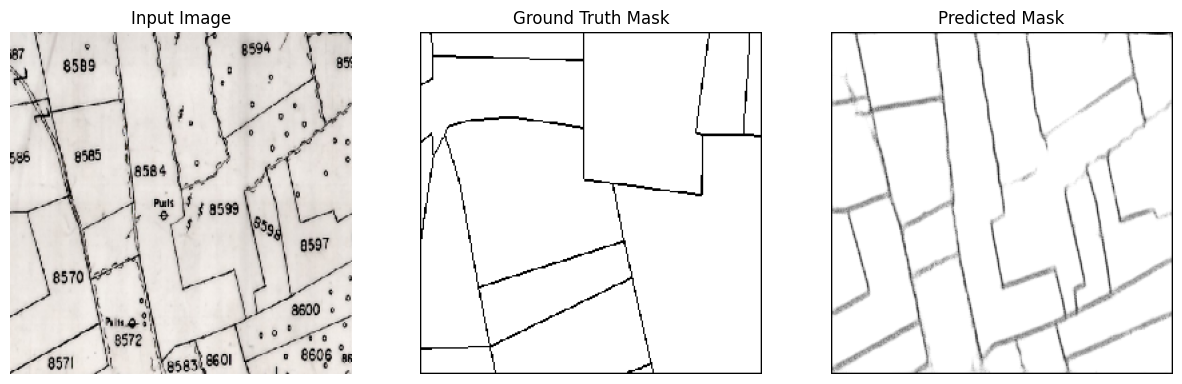

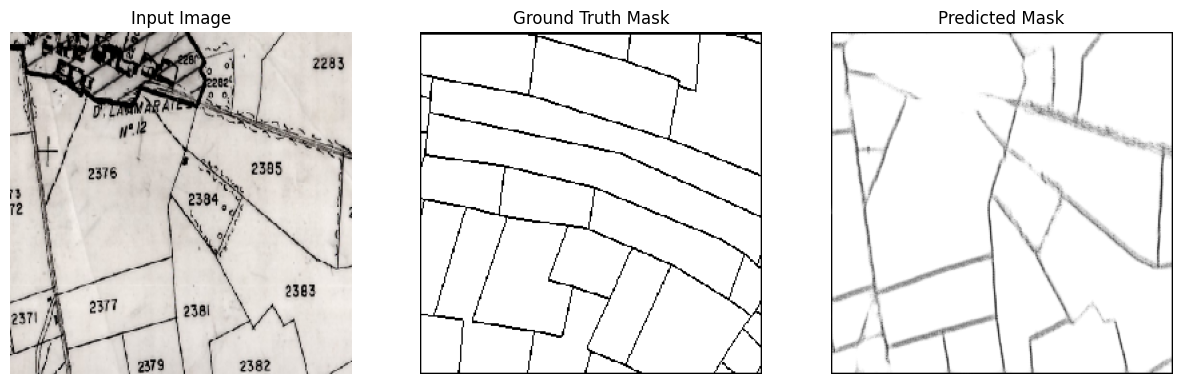

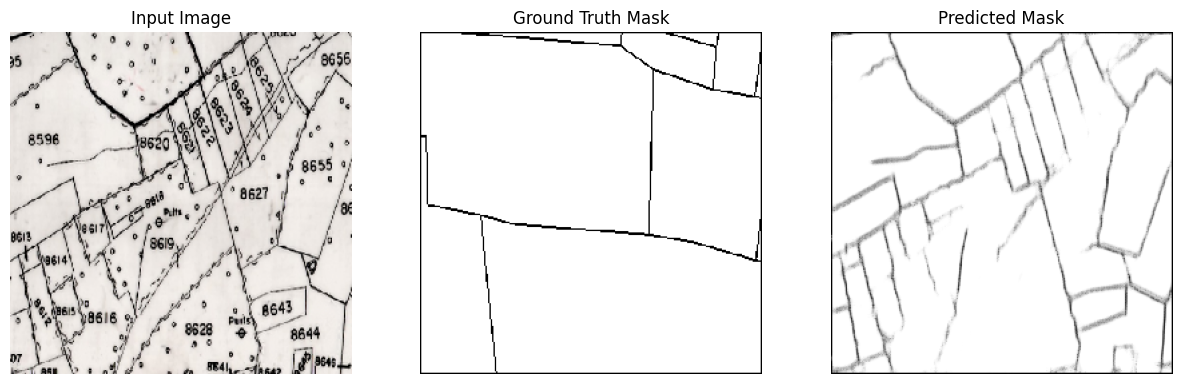

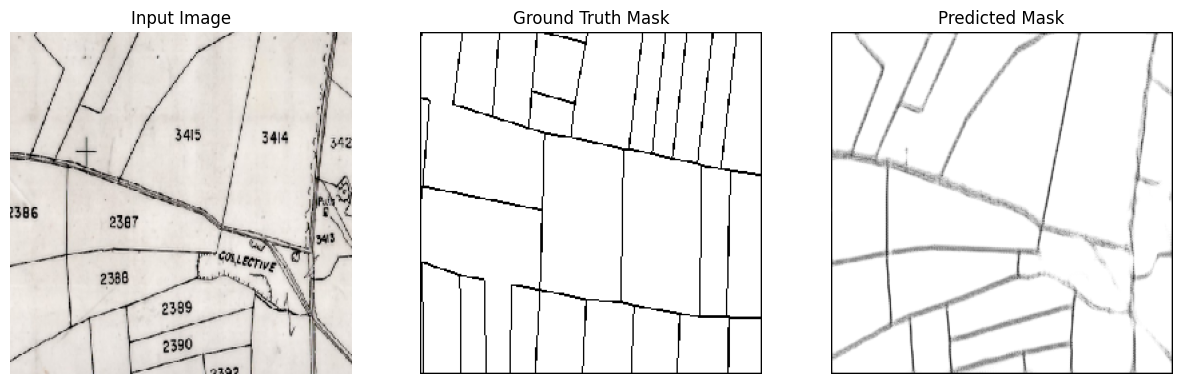

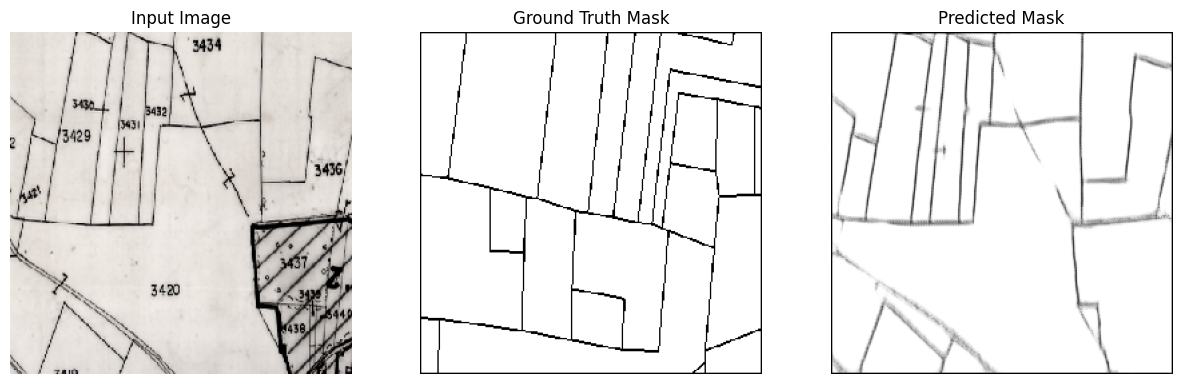

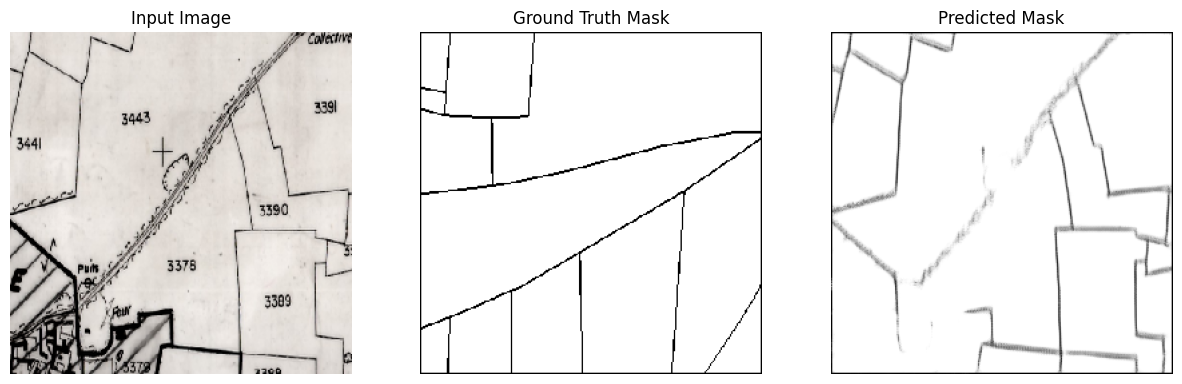

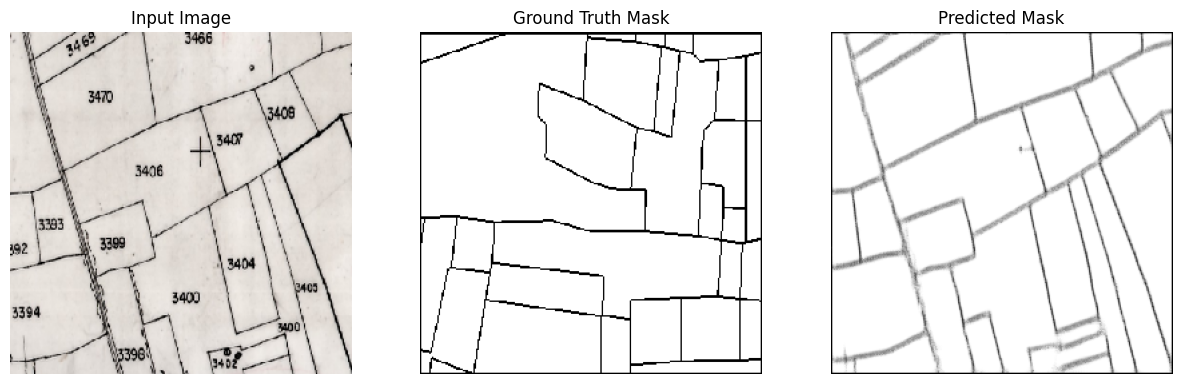

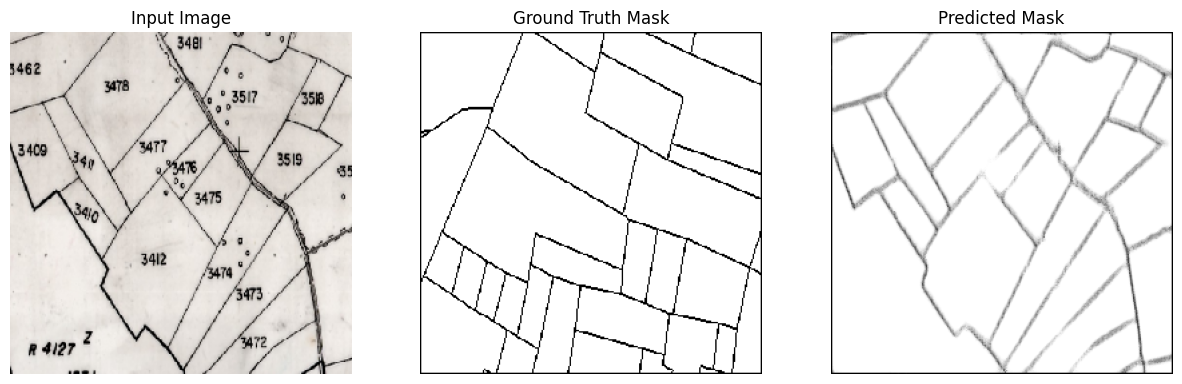

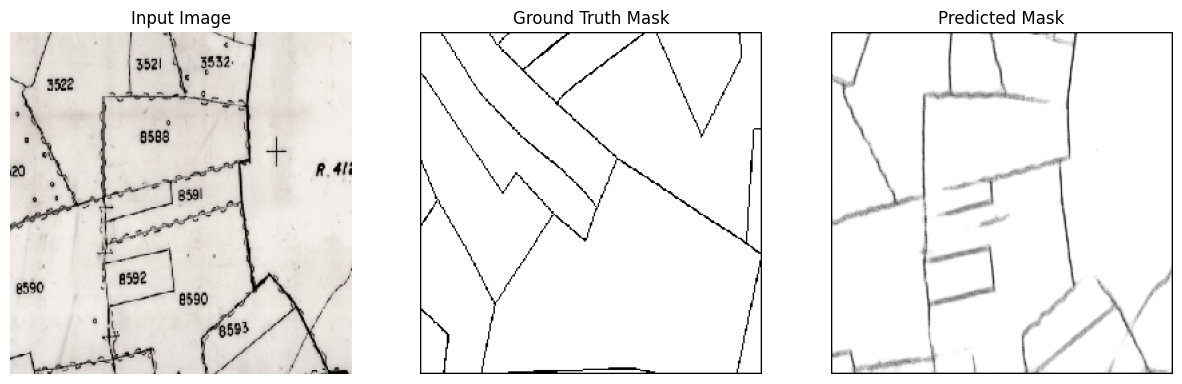

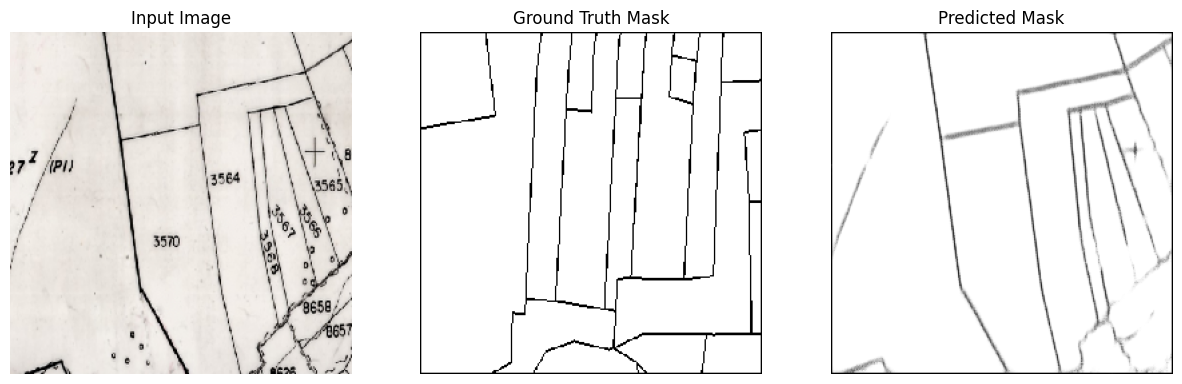

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2
import os

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/train/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

def remove_artifacts(image):
    # Convert image to 8-bit format (0-255 range)
    image_8bit = (image * 255).astype(np.uint8)
    
    # Convert image to grayscale for inpainting
    gray = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2GRAY)
    
    # Create a mask where white pixels represent the areas to be inpainted
    mask = np.zeros_like(gray)
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    
    # Inpaint the image to remove artifacts
    inpainted = cv2.inpaint(image_8bit, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    # Convert the image back to float format for consistency
    inpainted = inpainted.astype(np.float32) / 255.0
    return inpainted

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([remove_artifacts(load_image(img_path)) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=20)
